# Установка и импорт библиотек

In [1]:
# pip install numpy==1.24

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# !pip install phik -q
# !pip install shap -q
!pip install catboost -q
# !pip install xgboost -q
# !pip install lightgbm -q
!pip install lingua-language-detector -q
!pip install tqdm -q
!pip install pymystem3 -q
!pip install Mystem -q
!pip install torch -q
!pip install nltk -q
!pip install transformers -q

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cffi
ERROR: Could not build wheels for cffi, which is required to install pyproject.toml-based projects


In [4]:
import pandas as pd
import numpy as np
from numpy import sqrt
from numpy import argmax

from lingua import Language, LanguageDetectorBuilder
from concurrent.futures import ProcessPoolExecutor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import cross_val_predict

from sklearn.metrics import f1_score, make_scorer

import seaborn as sns
from matplotlib import pyplot as plt

# import phik
# import shap
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve

from sklearn.utils import shuffle

import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import transformers
from tqdm import notebook
from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
sns.set(style="darkgrid")

# Предобработка данных

## Загрузка и описание данных

In [7]:
covers = pd.read_json('/content/drive/MyDrive/YaMusic/covers.json', lines = True)
lyrics = pd.read_json('/content/drive/MyDrive/YaMusic/lyrics.json', lines = True)
meta = pd.read_json('/content/drive/MyDrive/YaMusic/meta.json', lines = True)

**Разметка каверов (covers)**

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

**Метаинформация (meta)**

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

**Текст песен (lyrics)**

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

In [8]:
covers

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER
...,...,...,...
71592,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,ORIGINAL
71593,None,78b2db35476f134dc3cdfbf4d77ba034,COVER
71594,None,e720ff378efe032df56e0e656a6a92d3,COVER
71595,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,ORIGINAL


In [9]:
lyrics

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659
...,...,...,...
11409,90522f12df92da5d585f8f6ec9bb34b5,All my little plans and schemes\nLost like som...,b734225e54122798535b40666e6e361e
11410,b82bd468c888ae17d2e976c8cf3b9d4c,I will make my way\nI'm trying to survive anot...,b3cbb82e4ef67e75b1e47054a681db86
11411,22bae9d3185254ea34072c692a2cd63d,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d
11412,0979b4049635e1c0fc161573f75ab23a,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d


In [10]:
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,[INDIE],212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,[POP],237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.0


## Поиск дубликатов

Дубликаты в таблице lyrics

In [11]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


In [12]:
lyrics[lyrics['track_id'].duplicated ()]

,lyricId,text,track_id
263,87966c7b6254c6298e18db41fea1b1a2,You ain't nothin' but a hound dog\nJust crocki...,ea09c90790b997b6e384d75d424b3ffe
494,74825f6c746beceb4da57cf80d7d6c10,For the longest time we jamming at the party\n...,dec84e10ae3ecc5c363f495724799322
502,4d0a6051746a18c918bae3926710cb97,You were the shadow to my light\nDid you feel ...,db69f2a265624a834d6e2a1238f6f225
590,4a95959841d857516385893009cfe841,You were the shadow to my light\nDid you feel ...,db69f2a265624a834d6e2a1238f6f225
616,74c0d9fdd29e454653bfa23ec57e2808,"All my friends are heathens, take it slow\nWai...",a367959976d3ca166beb46bdf66eefd0
...,...,...,...
11398,49df743c7a49ab4b90825282434f2e72,All the crazy shit I did tonight\nThose will b...,f66bf9c7becdeb7c4ce9c70722a2009c
11399,a16a7e2d216c914a505ec01102d57bb4,Now and then I think of when we were together\...,76cee823cdb700bb2d24f6db2c34587c
11408,da374afb1d2d6fbc85b40e68d22d2ab1,As he came into the window\nIt was the sound o...,53bf57b9e4d3eed991f57a603a41c9d4
11411,22bae9d3185254ea34072c692a2cd63d,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d


In [13]:
lyrics[lyrics['track_id']=='d5c149b59a800a6f9f61adda6d3e1b1d']

,lyricId,text,track_id
5946,6f4419a74d456f2ae5773c8b3701a003,You know every now and then\nI think you might...,d5c149b59a800a6f9f61adda6d3e1b1d
11411,22bae9d3185254ea34072c692a2cd63d,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d
11412,0979b4049635e1c0fc161573f75ab23a,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d


In [14]:
lyrics[lyrics['track_id'].duplicated()].nunique()

lyricId     1041
text         889
track_id     637
dtype: int64

Дубликаты в таблице meta

In [15]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


In [16]:
meta[meta['isrc'].duplicated()]

,track_id,dttm,title,language,isrc,genres,duration
2185,96f75d124808c84d823f09add1b6855c,1.640250e+12,Чижик-пыжик (А. Пинегин — А. Усачев),None,None,[FORCHILDREN],144560.0
2238,77bf68f7657ba9f87ee6ae7af3dc8999,1.640272e+12,Повторение счёта до 12,None,None,[FORCHILDREN],97720.0
2317,fb97e639240fb249756b40e0f88387cb,1.640334e+12,Глава 12. Пятно,None,None,[FAIRYTALES],103280.0
3838,be76b11b186c8f8a6afb34a23f64b132,1.642680e+12,Americano,None,None,[],225800.0
3839,57592bb19732a5b36568b96dd077b9fd,1.642680e+12,Снег идет,None,None,[],279560.0
...,...,...,...,...,...,...,...
71706,f3ce217d8dc57c625002748b79dba088,1.559822e+12,What is Love,None,None,[POP],309050.0
71707,b7b129d35cb8bdf149aad2f0ebbbad5d,1.559822e+12,Сильные люди,None,None,[POP],207540.0
71711,502c88c45642d08424def5082a346ab6,1.559861e+12,Donse Estas Yolanda,None,PLS921753675,[RELAX],209330.0
71715,e84ad641f17c306b25aeef4513722f07,1.559883e+12,Warwick Avenue,None,PLS921748007,"[CLASSICAL, CLASSICALMUSIC]",151200.0


In [17]:
a = meta[meta['isrc'].duplicated()]
a['isrc'].nunique()

169

In [18]:
meta[meta['isrc']=='PLS921753230']

,track_id,dttm,title,language,isrc,genres,duration
69215,3fff26c8e9cd5ae92c0793970e506cdd,1.550721e+12,Castle,None,PLS921753230,[],219160.0
71716,a12cf3d5db7975f54354a4b304bad783,1.559887e+12,Castle of Glass,None,PLS921753230,[],219160.0


In [19]:
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [20]:
b = covers[covers['track_id'].duplicated()]
b['track_id'].nunique()

0

In [21]:
covers['track_remake_type'].unique()

array(['ORIGINAL', 'COVER'], dtype=object)

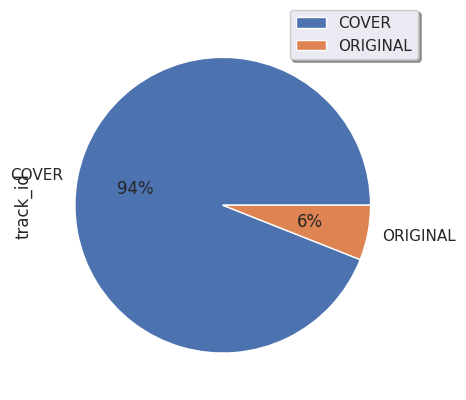

In [22]:
cover_pie = covers.groupby(['track_remake_type']).count().plot(kind='pie',  y='track_id', autopct='%1.0f%%',  legend=True)
cover_pie.legend(bbox_to_anchor=(1.05, 1.05),  fancybox=True, shadow=True)

In [23]:
only_cover = covers[covers['track_remake_type']=='COVER']
only_cover.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67304 entries, 4 to 71594
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  528 non-null    object
 1   track_id           67304 non-null  object
 2   track_remake_type  67304 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB


In [24]:
print('Количество уникальных значений оригинальных треков: ', len(only_cover['original_track_id'].unique()))

Количество уникальных значений оригинальных треков:  229


**Вывод:**
1. Датасет lyrics содержит дубликаты по track_id. в таблице lyrics нет пропусков.   
2. Датасет meta содержит 485 дубликата по столбцу isrc и большое количество пропусков в столбце language, так же есть пропущенные значения в столбце genre.   
3. Датасет covers не содержит дубликатов по track_id, есть пропущенные значения для original_track_id.   Ориганальные треки состаляют 6% датасета, каверы - 94%. Количество уникальных значений оригинальных треков - 229.



## Обработка датафрейма meta

ISRC код состоит из 12 символов и имеет следующую структуру:   
«CC-XXX-YY-NNNNN», где:

«CC» — это двухсимвольный код страны, в которой был зарегистрирован исполнитель или организация;  
«XXX» — это трехсимвольный код исполнителя или организации;  
«YY» — это двухсимвольный год, в котором был присвоен ISRC код;  
«NNNNN» — это пятизначный порядковый номер трека.  
Источник: https://chemodan-sale.ru/kak-uznat-isrc-treka

In [25]:
meta['title'].nunique()

45462

In [26]:
meta= meta.dropna(subset=['dttm'])

In [27]:
meta['dttm']  = pd.to_datetime(meta['dttm'] , unit='ms')

In [28]:
meta['isrc'] = meta['isrc'].str.replace('-','').astype(object)

In [29]:
meta['isrc'] = meta['isrc'].fillna(value=0)

In [30]:
meta['lang_reg'] = meta['isrc'].str[:2]
meta['artist'] = meta['isrc'].str[2:5]
meta['year_piblic'] = meta['isrc'].str[5:7]

In [31]:
meta['isrc'].nunique()

71284

In [32]:
meta[meta['isrc']=='USTCF1018565']

,track_id,dttm,title,language,isrc,genres,duration,lang_reg,artist,year_piblic
42675,734cfd17d9b91ed5e6040aeef988d8cc,2014-09-23 12:08:24,Breathe,None,USTCF1018565,"[ROCK, ALLROCK]",222010.0,US,TCF,10
67315,90117fc7a8a5ef80c4d3e1e6e39b4f06,2018-11-08 18:31:51,Breathe (2009),EN,USTCF1018565,"[ROCK, ALLROCK]",221970.0,US,TCF,10


In [33]:
meta['year_1'] = meta['dttm'].dt.year
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71768 entries, 0 to 71768
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   track_id     71768 non-null  object        
 1   dttm         71768 non-null  datetime64[ns]
 2   title        71768 non-null  object        
 3   language     21969 non-null  object        
 4   isrc         71768 non-null  object        
 5   genres       71768 non-null  object        
 6   duration     71768 non-null  float64       
 7   lang_reg     71455 non-null  object        
 8   artist       71455 non-null  object        
 9   year_piblic  71455 non-null  object        
 10  year_1       71768 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 6.6+ MB


In [34]:
meta['year_piblic'] = meta['year_piblic'].fillna(value=0)

In [35]:
 meta['year_piblic'] =  meta['year_piblic'].astype(int)

In [36]:
def function_year(year):
    if (year < 23) & (year > 0):
        return round(2000+year)
    elif year > 23 :
        return round(1900+year)
    elif year == 0 :
        return 0

In [37]:
 meta['year_piblic'] = meta['year_piblic'].apply(function_year)


In [38]:
meta

,track_id,dttm,title,language,isrc,genres,duration,lang_reg,artist,year_piblic,year_1
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0,RU,B42,2021.0,2021
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0,QZ,N88,2021.0,2021
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0,QZ,NJZ,2021.0,2021
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0,QZ,NJZ,2021.0,2021
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0,QZ,NJZ,2021.0,2021
...,...,...,...,...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,2019-06-13 05:20:09,Chanceuse,FR,CAISO1800023,[INDIE],212690.0,CA,ISO,2018.0,2019
71765,7cba0f30eaa8766d6c203eff2f3750a2,2019-06-13 13:34:03,Quiero Que Vuelvas,None,ES71G1738868,[POP],237540.0,ES,71G,2017.0,2019
71766,26b6aca1c6a02ad0e2a939164716657e,2019-06-13 17:50:02,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.0,US,A2B,2015.0,2019
71767,d904dda141238e6ad1b428bfbb21262d,2019-06-13 17:50:02,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.0,US,A2B,2015.0,2019


In [39]:
meta[meta['year_piblic'] > meta['year_1']]

,track_id,dttm,title,language,isrc,genres,duration,lang_reg,artist,year_piblic,year_1
504,940910a131dfe8741e7e67b51d039afa,2021-12-02 03:36:42,"Beginning (From ""Deltarune Chapter 1"")",None,AUXN22213224,[SOUNDTRACK],57000.0,AU,XN2,2022.0,2021
505,ad5f5c0fa005a7069fe5f26720ef5b64,2021-12-02 03:36:42,"Rude Buster (From ""Deltarune Chapter 1"")",None,AUXN22213225,[SOUNDTRACK],76000.0,AU,XN2,2022.0,2021
506,00644160ad2c52aa33bf63dce6956157,2021-12-02 03:36:42,"Field of Hopes and Dreams (From ""Deltarune Cha...",None,AUXN22213226,[SOUNDTRACK],147000.0,AU,XN2,2022.0,2021
507,2221c7e96548e930e5440a50689e987f,2021-12-02 03:36:42,"Checker Dance (From ""Deltarune Chapter 1"")",None,AUXN22213227,[SOUNDTRACK],80000.0,AU,XN2,2022.0,2021
508,f9a8c68dae5f678fc745409f319663ea,2021-12-02 03:36:42,"Scarlet Forest (From ""Deltarune Chapter 1"")",None,AUXN22213228,[SOUNDTRACK],135000.0,AU,XN2,2022.0,2021
...,...,...,...,...,...,...,...,...,...,...,...
70684,c52d3d8515b7d21d5e71dd8591dcf3f6,2019-04-13 01:53:15,Todo Mundo Odeia Acústico,None,QZ5AB2020509,[RAP],279940.0,QZ,5AB,2020.0,2019
70714,fc7e561be7c75f551c66d329f2b7a05a,2019-04-14 13:07:50,Вечеринка,None,QZ5AB2086123,[DANCE],252000.0,QZ,5AB,2020.0,2019
70927,80fa327671a78030d62108356e55182e,2019-04-20 03:46:14,Video Games,None,QZ5AB2076233,[POP],281630.0,QZ,5AB,2020.0,2019
70951,bf093a98d31e5b4298c1078077ca120a,2019-04-20 14:44:18,Casi Morí,None,QZ5AB2019901,[ALTERNATIVE],235780.0,QZ,5AB,2020.0,2019


In [40]:
meta[meta['track_id'] =='f9a8c68dae5f678fc745409f319663ea']

,track_id,dttm,title,language,isrc,genres,duration,lang_reg,artist,year_piblic,year_1
508,f9a8c68dae5f678fc745409f319663ea,2021-12-02 03:36:42,"Scarlet Forest (From ""Deltarune Chapter 1"")",None,AUXN22213228,[SOUNDTRACK],135000.0,AU,XN2,2022.0,2021


In [41]:
meta[meta['track_id'] =='87142a321554d3b17d18a265edd5c077']

,track_id,dttm,title,language,isrc,genres,duration,lang_reg,artist,year_piblic,year_1
71340,87142a321554d3b17d18a265edd5c077,2019-05-12 19:22:21,Summer Days,None,GBSMU2208539,[ELECTRONICS],152500.0,GB,SMU,2022.0,2019


In [42]:
meta['year_piblic'] = meta['year_piblic'].fillna(value=0)

In [43]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71768 entries, 0 to 71768
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   track_id     71768 non-null  object        
 1   dttm         71768 non-null  datetime64[ns]
 2   title        71768 non-null  object        
 3   language     21969 non-null  object        
 4   isrc         71768 non-null  object        
 5   genres       71768 non-null  object        
 6   duration     71768 non-null  float64       
 7   lang_reg     71455 non-null  object        
 8   artist       71455 non-null  object        
 9   year_piblic  71768 non-null  float64       
 10  year_1       71768 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 6.6+ MB


In [44]:
meta['year_piblic'] =  meta['year_piblic'].astype(int)

In [45]:
meta['year'] = meta[['year_piblic', 'year_1']].min(axis=1)

In [46]:
meta['year'].unique()

array([2021, 2018, 2020, 2022, 2019, 1999, 2001,    0, 2017, 2016, 2014,
       2012, 2008, 2005, 2015, 2009, 1982, 1930, 1933, 1977, 1936, 1935,
       1950, 1962, 2004, 1970, 1966, 2006, 2010, 1996, 1995, 2007, 2011,
       2003, 2013, 2002, 1924, 1981, 1973, 1960, 1971, 1965, 1938, 1985,
       1998, 1963, 1990, 1994, 1987, 1980, 1978, 1984, 1988, 1976, 1974,
       1979, 1992, 1989, 1991, 1986, 1997, 1983, 1951, 1993, 1925, 1942,
       1926, 1969, 1968, 1967, 1975, 1958, 1954, 1957, 1944, 1964])

In [47]:
meta['year'] = np.where((meta['year'] == 0), meta['year_1'], meta['year'])

In [48]:
meta['year'].unique()

array([2021, 2018, 2020, 2022, 2019, 1999, 2001, 2017, 2016, 2014, 2012,
       2008, 2005, 2015, 2009, 1982, 1930, 1933, 1977, 1936, 1935, 1950,
       1962, 2004, 1970, 1966, 2006, 2010, 1996, 1995, 2007, 2011, 2003,
       2013, 2002, 1924, 1981, 1973, 1960, 1971, 1965, 1938, 1985, 1998,
       1963, 1990, 1994, 1987, 1980, 1978, 1984, 1988, 1976, 1974, 1979,
       1992, 1989, 1991, 1986, 1997, 1983, 1951, 1993, 2023, 1925, 1942,
       1926, 1969, 1968, 1967, 1975, 1958, 1954, 1957, 1944, 1964])

In [49]:
languages = [Language.ENGLISH, Language.FRENCH, Language.GERMAN, Language.SPANISH, Language.RUSSIAN, Language.CHINESE, Language.ARABIC]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

def detect_lang(text):
  confidence_values = detector.compute_language_confidence_values(text)
  for language, value in confidence_values:
   return(f"{language.name}")

In [50]:
meta['lingua'] = meta['title'].apply(detect_lang)

In [51]:
meta

,track_id,dttm,title,language,isrc,genres,duration,lang_reg,artist,year_piblic,year_1,year,lingua
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0,RU,B42,2021,2021,2021,ENGLISH
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0,QZ,N88,2021,2021,2021,ENGLISH
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0,QZ,NJZ,2021,2021,2021,SPANISH
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0,QZ,NJZ,2021,2021,2021,SPANISH
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0,QZ,NJZ,2021,2021,2021,SPANISH
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,2019-06-13 05:20:09,Chanceuse,FR,CAISO1800023,[INDIE],212690.0,CA,ISO,2018,2019,2018,FRENCH
71765,7cba0f30eaa8766d6c203eff2f3750a2,2019-06-13 13:34:03,Quiero Que Vuelvas,None,ES71G1738868,[POP],237540.0,ES,71G,2017,2019,2017,SPANISH
71766,26b6aca1c6a02ad0e2a939164716657e,2019-06-13 17:50:02,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.0,US,A2B,2015,2019,2015,ENGLISH
71767,d904dda141238e6ad1b428bfbb21262d,2019-06-13 17:50:02,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.0,US,A2B,2015,2019,2015,ENGLISH


In [52]:
meta['lingua'].unique()

array(['ENGLISH', 'SPANISH', 'FRENCH', 'GERMAN', 'RUSSIAN', 'ARABIC',
       'CHINESE'], dtype=object)

In [53]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71768 entries, 0 to 71768
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   track_id     71768 non-null  object        
 1   dttm         71768 non-null  datetime64[ns]
 2   title        71768 non-null  object        
 3   language     21969 non-null  object        
 4   isrc         71768 non-null  object        
 5   genres       71768 non-null  object        
 6   duration     71768 non-null  float64       
 7   lang_reg     71455 non-null  object        
 8   artist       71455 non-null  object        
 9   year_piblic  71768 non-null  int64         
 10  year_1       71768 non-null  int64         
 11  year         71768 non-null  int64         
 12  lingua       71768 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 7.7+ MB


In [54]:
meta['genres'] = meta['genres'].apply(lambda x: ' '.join(x))

In [55]:
meta['genres'].unique()

array(['DANCE', 'ELECTRONICS', 'FOLK LATINFOLK', 'JAZZ CONJAZZ', 'POP',
       'POP FOLK LATINFOLK', 'FOLK', 'SOUL RNB', 'PUNK', 'ROCK ALLROCK',
       'ALTERNATIVE', 'JAZZ', 'SOUNDTRACK', 'SPIRITUAL',
       'CLASSICMETAL METAL', 'ALLROCK RNR', 'SOUNDTRACK ANIMEMUSIC',
       'ESTRADA', 'ELECTRONICS HOUSE', 'POP RUSPOP', 'FOREIGNBARD BARD',
       'CLASSICAL CLASSICALMUSIC', 'FOREIGNRAP RAP', 'RAP', 'COUNTRY',
       'RUSRAP RAP', 'ELECTRONICS AMBIENTGENRE', 'REGGAE REGGAETON',
       'CHILDREN', '', 'BLUES', 'CLASSICALMUSIC VOCAL', 'RUSROCK ALLROCK',
       'FOLK AFRICAN', 'INDIE', 'POP DANCE RUSPOP RNB',
       'FOLKROCK ALLROCK', 'POP ASIAPOP', 'NEWAGE ELECTRONICS',
       'FOLK CAUCASIAN', 'EASTERN FOLK', 'REGGAE', 'FORCHILDREN', 'RELAX',
       'SKA', 'METAL', 'METAL BLACKMETAL', 'POP ELECTRONICS DNB',
       'POP DANCE DISCO', 'PROGMETAL METAL', 'FOLK AMERFOLK', 'RNB',
       'LOCAL-INDIE INDIE', 'POP DISCO', 'ELECTRONICS DNB',
       'DANCE PHONKGENRE', 'VIDEOGAME SOUNDTRACK', 

In [56]:
def categorize_genres(genre):
    if 'BARD' in genre:
        return 'BARD'
    elif 'FOLK' in genre:
        return 'FOLK'
    elif 'REGGAE' in genre:
        return 'REGGAE'
    elif 'SOUNDTRACK' in genre:
        return 'SOUNDTRACK'
    elif 'CHILDREN' in genre:
        return 'CHILDREN'
    elif 'DANCE' in genre:
        return 'DANCE'
    elif 'JAZZ' in genre:
        return 'JAZZ'
    elif 'ROCK' in genre:
        return 'ROCK'
    elif 'METAL' in genre:
        return 'METAL'
    elif 'RAP' in genre:
        return 'RAP'
    elif 'SOUL' in genre:
        return 'SOUL'
    elif 'ELECTRONICS' in genre:
        return 'ELECTRONICS'
    elif 'INDIE' in genre:
        return 'INDIE'
    elif 'ALTERNATIVE' in genre:
        return 'ALTERNATIVE'
    elif 'POP' in genre:
        return 'POP'
    elif 'PUNK' in genre:
        return 'PUNK'
    elif 'SPIRITUAL' in genre:
        return 'SPIRITUAL'
    elif 'ESTRADA' in genre:
        return 'ESTRADA'
    elif 'CLASSICAL' in genre:
        return 'CLASSICAL'
    elif 'RNB' in genre:
        return 'RNB'
    elif 'RELAX' in genre:
        return 'RELAX'
    elif 'BARD' in genre:
        return 'BARD'
    else:
      return genre


meta['genres'] = meta['genres'].apply(categorize_genres)

In [57]:
meta['genres'].unique()

array(['DANCE', 'ELECTRONICS', 'FOLK', 'JAZZ', 'POP', 'SOUL', 'PUNK',
       'ROCK', 'ALTERNATIVE', 'SOUNDTRACK', 'SPIRITUAL', 'METAL',
       'ESTRADA', 'BARD', 'CLASSICAL', 'RAP', 'COUNTRY', 'REGGAE',
       'CHILDREN', '', 'BLUES', 'INDIE', 'RELAX', 'SKA', 'RNB',
       'FAIRYTALES', 'BOOKSNOTINRUSSIAN', 'SPOKEN', 'SHANSON', 'SPORT'],
      dtype=object)

In [58]:
meta['genres'].nunique()

30

In [59]:
meta['duration'] = meta['duration']/1000

In [60]:
meta.head(10)


,track_id,dttm,title,language,isrc,genres,duration,lang_reg,artist,year_piblic,year_1,year,lingua
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,DANCE,161.12,RU,B42,2021,2021,2021,ENGLISH
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,ELECTRONICS,362.26,QZ,N88,2021,2021,2021,ENGLISH
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,FOLK,260.00,QZ,NJZ,2021,2021,2021,SPANISH
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,FOLK,190.00,QZ,NJZ,2021,2021,2021,SPANISH
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,FOLK,203.00,QZ,NJZ,2021,2021,2021,SPANISH
5,551331ee1444de6658e71933eb7f57a2,2021-11-24 15:37:03,La Ultima Vez,None,QZNJZ2166034,FOLK,173.00,QZ,NJZ,2021,2021,2021,SPANISH
6,2be8bb01bb1aeef0908524dc11935a88,2021-11-24 15:37:03,Homenaje a Pastor de los Santos,None,QZNJZ2122553,FOLK,192.10,QZ,NJZ,2021,2021,2021,SPANISH
7,3883d1add3ff8b60e77548a64df7c892,2021-11-24 15:37:03,Los Marginales,None,QZNJZ2122554,FOLK,311.50,QZ,NJZ,2021,2021,2021,SPANISH
8,59aa886979699aa7e4e2a8aed43bfe03,2021-11-24 15:37:03,Cuenta Conmigo,None,QZNJZ2122555,FOLK,250.00,QZ,NJZ,2021,2021,2021,SPANISH
9,2a38992b7769963937246288ad89b44c,2021-11-24 15:37:03,Ahora Juego Yo,None,QZNJZ2122556,FOLK,156.00,QZ,NJZ,2021,2021,2021,SPANISH


In [61]:
genres = meta.groupby(['genres']).count().reset_index()
genres['%']= genres['track_id']/71768
genres = genres.drop(columns=['track_id', 'dttm', 'title', 'isrc',  'duration', 'language', 'lang_reg', 'artist', 'year'], axis=1).sort_values(by='%', ascending=False)
genres # можно сделать поменьше жанров, объединить

,genres,year_piblic,year_1,lingua,%
12,FOLK,21650,21650,21650,0.301666
16,POP,14958,14958,14958,0.208422
22,ROCK,6612,6612,6612,0.092130
1,ALTERNATIVE,3744,3744,3744,0.052168
9,ELECTRONICS,3342,3342,3342,0.046567
26,SOUNDTRACK,2759,2759,2759,0.038443
18,RAP,2521,2521,2521,0.035127
0,,2352,2352,2352,0.032772
8,DANCE,2325,2325,2325,0.032396
15,METAL,2173,2173,2173,0.030278


Объединение данных в один датасет

In [62]:
data = covers.merge(meta, on='track_id', how='left')
data = data.merge(lyrics, on='track_id', how='left')

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72571 entries, 0 to 72570
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  5378 non-null   object        
 1   track_id           72571 non-null  object        
 2   track_remake_type  72571 non-null  object        
 3   dttm               72571 non-null  datetime64[ns]
 4   title              72571 non-null  object        
 5   language           22598 non-null  object        
 6   isrc               72571 non-null  object        
 7   genres             72571 non-null  object        
 8   duration           72571 non-null  float64       
 9   lang_reg           72242 non-null  object        
 10  artist             72242 non-null  object        
 11  year_piblic        72571 non-null  int64         
 12  year_1             72571 non-null  int64         
 13  year               72571 non-null  int64         
 14  lingua

In [64]:
data.head(10)

,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,lang_reg,artist,year_piblic,year_1,year,lingua,lyricId,text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,ROCK,187.22,US,FI8,1969,2009,1969,ENGLISH,260f21d9f48e8de874a6e844159ddf28,Left a good job in the city\nWorkin' for the m...
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,ROCK,187.22,US,FI8,1969,2009,1969,ENGLISH,f3331cf99637ee24559242d13d8cf259,Left a good job in the city\nWorkin' for the m...
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,2009-11-11 21:00:00,Fortunate Son,EN,USFI86900065,ROCK,137.78,US,FI8,1969,2009,1969,ENGLISH,2498827bd11eca5846270487e4960080,Some folks are born made to wave the flag\nOoh...
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,2009-09-21 20:00:00,La Camisa Negra,ES,USUL10400965,FOLK,216.84,US,UL1,2004,2009,2004,SPANISH,5237001311d4062bf2b80de30652bf58,"Uno por pobre y feo, hombre\nPero antoja'o, ay..."
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,RAP,179.66,US,UM7,2007,2009,2007,ENGLISH,e5b1b57090b728e8d98d2b4d9b781bf4,"Yeah!... yeah!... remember the time, baby... y..."
5,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,RAP,179.66,US,UM7,2007,2009,2007,ENGLISH,b6625d84706fefe8782e63bd36067bc2,In a state of emergency...\n\nI ain't got no m...
6,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,RAP,179.66,US,UM7,2007,2009,2007,ENGLISH,4b30eb13f54a1d83f34202ab8e8a3357,"(State of emergency)\nYeah, yeah (yeah) (oh ye..."
7,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,RAP,179.66,US,UM7,2007,2009,2007,ENGLISH,7d460b001efe698d9fb4d47059099913,In a state of emergency...\n\nI ain't got no m...
8,None,d6288499d0083cc34e60a077b7c4b3e1,COVER,2009-09-17 20:00:00,Extraball,EN,FR8Q10900116,ELECTRONICS,212.62,FR,8Q1,2009,2009,2009,SPANISH,NaN,NaN
9,None,4da9d7b6d119db4d2d564a2197798380,COVER,2009-09-17 20:00:00,Can't Buy Me Love,EN,USGR10110569,JAZZ,158.95,US,GR1,2001,2009,2001,ENGLISH,58b6145f2fb180f8cdc2067b4f1baebd,Can't buy me love\nCan't buy me love\nCan't bu...


In [65]:
data =data.drop_duplicates(subset=['original_track_id', 'track_id'])

In [66]:
data['artist'] = data['artist'].fillna(0)

In [67]:
data['text'] = data['text'].fillna(' ')

In [68]:
data['lingua_text'] = data['text'].apply(detect_lang)

In [69]:
data = data.drop(columns=['dttm', 'lang_reg', 'lyricId', 'isrc', 'year_piblic', 'year_1','language'], axis=1)

In [70]:
# data[data['isrc']=='USWWW0202466']

In [71]:
data[data['track_id']=='d5c149b59a800a6f9f61adda6d3e1b1d']

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
18466,eeb69a3cb92300456b6a5f4162093851,d5c149b59a800a6f9f61adda6d3e1b1d,COVER,Proud Mary,DANCE,213.66,6ZW,2014,ENGLISH,You know every now and then\nI think you might...,ENGLISH


In [72]:
def function_target(track_remake_type):
    if track_remake_type == 'ORIGINAL':
        return 0
    if track_remake_type == 'COVER':
        return 1

data['track_remake_type'] = data['track_remake_type'].apply(function_target)

In [73]:
data.head(10)

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,0,Proud Mary,ROCK,187.22,FI8,1969,ENGLISH,Left a good job in the city\nWorkin' for the m...,ENGLISH
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,0,Fortunate Son,ROCK,137.78,FI8,1969,ENGLISH,Some folks are born made to wave the flag\nOoh...,ENGLISH
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,0,La Camisa Negra,FOLK,216.84,UL1,2004,SPANISH,"Uno por pobre y feo, hombre\nPero antoja'o, ay...",SPANISH
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,0,The Way I Are,RAP,179.66,UM7,2007,ENGLISH,"Yeah!... yeah!... remember the time, baby... y...",ENGLISH
8,None,d6288499d0083cc34e60a077b7c4b3e1,1,Extraball,ELECTRONICS,212.62,8Q1,2009,SPANISH,,ARABIC
9,None,4da9d7b6d119db4d2d564a2197798380,1,Can't Buy Me Love,JAZZ,158.95,GR1,2001,ENGLISH,Can't buy me love\nCan't buy me love\nCan't bu...,ENGLISH
10,None,2bf283c05b601f21364d052ca0ec798d,1,She's Leaving Home,JAZZ,356.07,GR1,1999,ENGLISH,Wednesday morning at five o'clock\nAs the day ...,ENGLISH
11,None,5eb13cb69b6e20dd7a42030f5936a9dc,1,Warning,METAL,628.34,AJE,1970,ENGLISH,Now the first day that I met you\nI was lookin...,ENGLISH
12,None,109f91266ef89cc3690079b28abfe9a3,1,"Evil Woman, Don't Play Your Games With Me",METAL,202.99,AJE,1970,ENGLISH,I've seen a look of evil in your eyes\nYou've ...,ENGLISH
13,76c538125fc5c9ec6ad1d05650a57de5,76c538125fc5c9ec6ad1d05650a57de5,0,Just A Lil Bit,RAP,239.18,IR1,2005,ENGLISH,"Yeah, Shady, Aftermath, G-Unit!\n\nDamn baby a...",ENGLISH


In [74]:
data[data['lingua']!=data['lingua_text']]

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
8,None,d6288499d0083cc34e60a077b7c4b3e1,1,Extraball,ELECTRONICS,212.62,8Q1,2009,SPANISH,,ARABIC
20,None,bac4cbb6173335e862a1b3df635ee3ba,1,Bend,METAL,629.91,UM7,2008,GERMAN,,ARABIC
39,None,d7c3f8dee9f1ce4c631160e82f1ec938,1,Live And Let Die,ROCK,182.20,GF1,1991,GERMAN,,ARABIC
40,None,cbb686245ece57c9827c4bc0d0654a8e,1,Have You Ever Seen The Rain,JAZZ,239.62,FI8,1975,ENGLISH,,ARABIC
49,None,c8c83f959021e1042efa4c5146754409,1,Wonderwall,ROCK,248.62,MR1,2003,GERMAN,Today is gonna be the day\nThat they're gonna ...,ENGLISH
...,...,...,...,...,...,...,...,...,...,...,...
72566,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,0,"Милый, прощай",POP,178.98,AGT,2023,RUSSIAN,,ARABIC
72567,None,78b2db35476f134dc3cdfbf4d77ba034,1,Habits (Stay Hight),ELECTRONICS,149.57,AHK,2023,ENGLISH,,ARABIC
72568,None,e720ff378efe032df56e0e656a6a92d3,1,Arcade,BARD,201.58,AHM,2023,SPANISH,,ARABIC
72569,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,0,Май,RAP,156.87,RUS,2023,RUSSIAN,,ARABIC


In [75]:
data[data['lingua']=='ARABIC']

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
750,None,1e46771541b1ce02ca249e82c890ccd7,1,รักที่เพิ่งผ่านพ้นไป,POP,324.93,S08,2006,ARABIC,เคยนั่งตรงนี้ เก้าอี้ตัวนี้ อยู่ข้างๆเธอ เป็นท...,ARABIC
752,None,9be2032b43b6f5970e04fda08ae921eb,1,คืนใจ,POP,249.89,S08,2006,ARABIC,,ARABIC
771,None,603caa39fa8501cf386af99ed351bb0f,1,1999,ELECTRONICS,314.37,A37,2006,ARABIC,,ARABIC
1051,None,048ab92a8b0555d6218a5dfe35afaa45,1,3 1/2,PUNK,141.24,A56,2006,ARABIC,,ARABIC
1172,None,2a1231e0d69201158c90f7ecebc85dc5,1,1979,ELECTRONICS,299.02,A37,2005,ARABIC,,ARABIC
...,...,...,...,...,...,...,...,...,...,...,...
70514,None,4d1b5674bd2c6e2455635d78a48af57b,1,สวยจนล้น,FOLK,202.30,NJY,2022,ARABIC,,ARABIC
71139,8f9dd56bdeb9ada69cd291899f52d5a8,8f9dd56bdeb9ada69cd291899f52d5a8,0,5000,DANCE,155.45,8KE,2022,ARABIC,,ARABIC
71450,32bd5bf27363abbc356b5fd394d66aee,32bd5bf27363abbc356b5fd394d66aee,0,1 0 0 1 1,DANCE,142.98,MA6,2019,ARABIC,I love you from afar\nWith knowing that the sk...,ENGLISH
71673,e710cc10abdd5b16107c71d231a52df1,e710cc10abdd5b16107c71d231a52df1,0,24:00,POP,187.42,B42,2022,ARABIC,Город красиво горит\nЯрким светом залит\nИ мы ...,RUSSIAN


In [76]:
data_1 = data[data['text']!=' ']
data_1

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,0,Proud Mary,ROCK,187.22,FI8,1969,ENGLISH,Left a good job in the city\nWorkin' for the m...,ENGLISH
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,0,Fortunate Son,ROCK,137.78,FI8,1969,ENGLISH,Some folks are born made to wave the flag\nOoh...,ENGLISH
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,0,La Camisa Negra,FOLK,216.84,UL1,2004,SPANISH,"Uno por pobre y feo, hombre\nPero antoja'o, ay...",SPANISH
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,0,The Way I Are,RAP,179.66,UM7,2007,ENGLISH,"Yeah!... yeah!... remember the time, baby... y...",ENGLISH
9,None,4da9d7b6d119db4d2d564a2197798380,1,Can't Buy Me Love,JAZZ,158.95,GR1,2001,ENGLISH,Can't buy me love\nCan't buy me love\nCan't bu...,ENGLISH
...,...,...,...,...,...,...,...,...,...,...,...
72495,1204c297dac3630a3478ec9399f227f8,1204c297dac3630a3478ec9399f227f8,0,Красные розы,SHANSON,168.32,A1D,2023,RUSSIAN,Познакомился с тобою\nБукет роз подарил\nНо пр...,RUSSIAN
72500,49eb14162a12646682bd2024b093ea15,49eb14162a12646682bd2024b093ea15,0,Поспешили,RAP,126.72,RUS,2023,RUSSIAN,Ты берёшь за душу\nА я беру за руку\nНо обжига...,RUSSIAN
72502,dd3b864285b4cdcd2363985ec12bbcfa,dd3b864285b4cdcd2363985ec12bbcfa,0,В моей крови,POP,195.31,AGV,2023,RUSSIAN,Я\nКогда-нибудь замёрзну в этом городе\nТуман ...,RUSSIAN
72503,1dd3cbe5aafe4e3fe246abbed7850c01,1dd3cbe5aafe4e3fe246abbed7850c01,0,Не смогу забыть,POP,151.50,AGV,2023,RUSSIAN,Я не смогу забыть тебя\nНе могу забыть твой вз...,RUSSIAN


In [77]:
data_1[data_1['lingua'] != data_1['lingua_text']] #Будем ли мы бороться с этим моментом?

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
49,None,c8c83f959021e1042efa4c5146754409,1,Wonderwall,ROCK,248.62,MR1,2003,GERMAN,Today is gonna be the day\nThat they're gonna ...,ENGLISH
74,249e0710272ffdc8a91dd80b2e24eb2d,249e0710272ffdc8a91dd80b2e24eb2d,0,Zombie,ROCK,307.43,IR2,1994,FRENCH,Another head hangs lowly\nChild is slowly take...,ENGLISH
85,None,dc0c11952bfc275612cbc3986021684f,1,Cocaine,ROCK,218.10,F05,1977,FRENCH,"If you wanna hang out, you've gotta take her o...",ENGLISH
114,None,4df9b34ea36ad02818ca526edcc64cb2,1,Sabbra Cadabra,METAL,380.24,AMC,1998,GERMAN,"Feel so good, I feel so fine\nLove that little...",ENGLISH
115,None,3dc09677e0fdb539a31d497c4fb25f20,1,Am I Evil?,METAL,470.06,AMC,1984,SPANISH,"My mother was a witch, she was burned alive\nT...",ENGLISH
...,...,...,...,...,...,...,...,...,...,...,...
72445,5e7b86c6e292fd77522b97932055d43a,5e7b86c6e292fd77522b97932055d43a,0,HOUSE SERENADA,POP,157.24,A1D,2023,SPANISH,"Нет запретов, больше чем любовь, ты лето\nТы м...",RUSSIAN
72449,None,334657a315344e1687c683de7297e4b1,1,Prekrasnoe Dalyoko,SOUNDTRACK,120.98,A1D,2023,GERMAN,Слышу голос из прекрасного далёко\nГолос утрен...,RUSSIAN
72452,None,2a72ce548d172eda9964a2bbb6c4e08e,1,Zombie,DANCE,171.27,8KE,2023,FRENCH,Another head hangs lowly\nChild is slowly take...,ENGLISH
72453,8d149baf1fb8af6c3134d2c733f28095,8d149baf1fb8af6c3134d2c733f28095,0,money,POP,161.44,A07,2023,ENGLISH,I got a problems\nВ салоне сломанный хаус\nБол...,RUSSIAN


In [78]:
data[data['lingua']=='ARABIC']

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
750,None,1e46771541b1ce02ca249e82c890ccd7,1,รักที่เพิ่งผ่านพ้นไป,POP,324.93,S08,2006,ARABIC,เคยนั่งตรงนี้ เก้าอี้ตัวนี้ อยู่ข้างๆเธอ เป็นท...,ARABIC
752,None,9be2032b43b6f5970e04fda08ae921eb,1,คืนใจ,POP,249.89,S08,2006,ARABIC,,ARABIC
771,None,603caa39fa8501cf386af99ed351bb0f,1,1999,ELECTRONICS,314.37,A37,2006,ARABIC,,ARABIC
1051,None,048ab92a8b0555d6218a5dfe35afaa45,1,3 1/2,PUNK,141.24,A56,2006,ARABIC,,ARABIC
1172,None,2a1231e0d69201158c90f7ecebc85dc5,1,1979,ELECTRONICS,299.02,A37,2005,ARABIC,,ARABIC
...,...,...,...,...,...,...,...,...,...,...,...
70514,None,4d1b5674bd2c6e2455635d78a48af57b,1,สวยจนล้น,FOLK,202.30,NJY,2022,ARABIC,,ARABIC
71139,8f9dd56bdeb9ada69cd291899f52d5a8,8f9dd56bdeb9ada69cd291899f52d5a8,0,5000,DANCE,155.45,8KE,2022,ARABIC,,ARABIC
71450,32bd5bf27363abbc356b5fd394d66aee,32bd5bf27363abbc356b5fd394d66aee,0,1 0 0 1 1,DANCE,142.98,MA6,2019,ARABIC,I love you from afar\nWith knowing that the sk...,ENGLISH
71673,e710cc10abdd5b16107c71d231a52df1,e710cc10abdd5b16107c71d231a52df1,0,24:00,POP,187.42,B42,2022,ARABIC,Город красиво горит\nЯрким светом залит\nИ мы ...,RUSSIAN


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71597 entries, 0 to 72570
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  4821 non-null   object 
 1   track_id           71597 non-null  object 
 2   track_remake_type  71597 non-null  int64  
 3   title              71597 non-null  object 
 4   genres             71597 non-null  object 
 5   duration           71597 non-null  float64
 6   artist             71597 non-null  object 
 7   year               71597 non-null  int64  
 8   lingua             71597 non-null  object 
 9   text               71597 non-null  object 
 10  lingua_text        71597 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 6.6+ MB


# Подготовка данных для построения модели

In [80]:
RANDOM_STATE = 123456

In [81]:
features = data.drop(['track_remake_type', 'text'], axis=1)
target = data['track_remake_type']

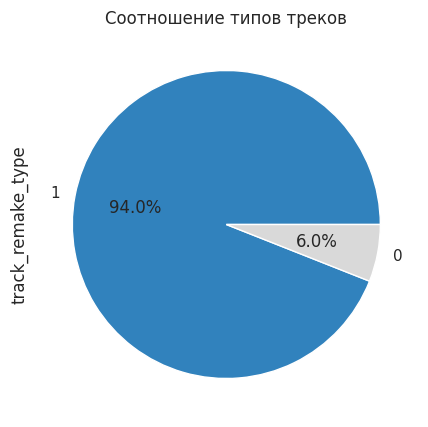

In [82]:
target.value_counts().plot.pie(title = 'Соотношение типов треков' ,
                                                 colormap = 'tab20c', figsize = (5,5), autopct='%1.1f%%')
plt.show()

Данные не сбалансированы. Необходимо это учесть при построении моделей

In [83]:
features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target,
                                                                            test_size=0.15, random_state=RANDOM_STATE)

In [84]:
print('Размер тренировочной выборки:', len(features_train)/len(data))
print('Размер тестовой выборки:', len(features_test)/len(data))

Размер тренировочной выборки: 0.8499937148204534
Размер тестовой выборки: 0.15000628517954662


In [85]:
features_train.columns

Index(['original_track_id', 'track_id', 'title', 'genres', 'duration',
       'artist', 'year', 'lingua', 'lingua_text'],
      dtype='object')

In [86]:
features_train

,original_track_id,track_id,title,genres,duration,artist,year,lingua,lingua_text
19348,None,fbe76e676348e6c9249a86d460769cd7,Воздух,ELECTRONICS,231.79,LZJ,2019,RUSSIAN,RUSSIAN
17559,8e6825dc6b2030dbd5953b5139837b37,8e6825dc6b2030dbd5953b5139837b37,Любимка,POP,219.69,2X4,2019,RUSSIAN,RUSSIAN
23707,None,eb870e3538e86f8ee3eabf99904d67cd,Delante de Mí Detente lo Más Que Puedas,FOLK,154.47,A01,2019,SPANISH,ARABIC
37158,None,137583e5fa336c048b12dd587dedb475,Sabrás,POP,272.90,HZ3,2021,SPANISH,ARABIC
63737,None,a812711bf5886f2cfb327cf88147755e,Aguzate,FOLK,245.24,5AB,2022,FRENCH,ARABIC
...,...,...,...,...,...,...,...,...,...
46898,None,35085f3a2d18dd06f7375bd76406ce46,A General Urquiza,FOLK,132.72,NJV,2021,SPANISH,ARABIC
51555,None,5c483d848c2bc1187a754dec5cdce058,Me Acuerdo,RAP,351.46,NJX,2021,SPANISH,ARABIC
12584,None,0527b341789864caf6288d641176ce7a,God's Plan,POP,188.25,10S,2018,ENGLISH,ARABIC
55081,None,de1af972b264e087bb30b7ba975923d3,Tiroteo,REGGAE,320.69,NJY,2021,SPANISH,ARABIC


In [87]:
cat_features = ['original_track_id', 'track_id',  'title',
       'genres',  'artist', 'lingua', 'lingua_text']

In [88]:
num_features = ['year', 'duration']

In [89]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), num_features),
        ('cat', Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))    ]), cat_features)
    ]
)

# Модель на всех данных

### RandomForestClassifier

In [90]:
features_train_rfc = features_train.copy()
features_test_rfc = features_test.copy()
target_train_rfc = target_train.copy()
target_test_rfc= target_train.copy()

In [91]:
# features_train_rfc = features_train_rfc.fillna('')
# features_test_rfc = features_test_rfc.fillna('')

In [92]:
features_test_rfc

,original_track_id,track_id,title,genres,duration,artist,year,lingua,lingua_text
69792,None,509adc2b601b724e96093a64f49ebfb2,Fuego en Animaná,CLASSICAL,0.00,NJY,2021,SPANISH,ARABIC
54707,None,33b0743f9d2c84b700390057d29e8d31,Paranoid,POP,178.07,E83,2009,SPANISH,ENGLISH
27825,None,c90e39c047a659c4a5a760603fc8bc87,Skandal im Sperrbezirk,ROCK,194.21,GWX,2020,GERMAN,ARABIC
49642,None,020a5e3214ed1f1284a192abc6c43615,"Brave Song (From ""Angel Beats!"")",SOUNDTRACK,211.42,XN2,2021,ENGLISH,ARABIC
6871,None,a537165879660901e1ff59beca978a89,"Young, Wild & Free",POP,207.86,CRP,2012,ENGLISH,ARABIC
...,...,...,...,...,...,...,...,...,...
1451,None,0fa347532d6176d4c93c8a33798846c3,The Phantom of the Opera,SOUNDTRACK,251.13,A56,2009,ENGLISH,ARABIC
54032,None,a7f3ddeaa6b9590b40174a84d7bfc8cf,Como Si No Importara,FOLK,171.52,NJY,2021,SPANISH,ARABIC
52618,None,bae6134cd58ebfe55b9acb9a340c1276,"Home, Andrew York, Guitarra",,239.14,NJX,2021,ENGLISH,ARABIC
46653,None,2ad2a5ae951b564073a524cd17f00ad1,Meu Pedaço de Pecado,FOLK,147.23,NJV,2021,SPANISH,ARABIC


In [93]:
features_train_rfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60857 entries, 19348 to 5102
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  4097 non-null   object 
 1   track_id           60857 non-null  object 
 2   title              60857 non-null  object 
 3   genres             60857 non-null  object 
 4   duration           60857 non-null  float64
 5   artist             60857 non-null  object 
 6   year               60857 non-null  int64  
 7   lingua             60857 non-null  object 
 8   lingua_text        60857 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.6+ MB


In [94]:
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('rfc', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['original_track_id',
                                                   'track_id', 'title',
                                                   'genres', 'artist', 'lingua',
                                                   'lingua_text'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=123456))])

In [95]:
f1 = make_scorer(f1_score , average='macro')

In [96]:
# %time
# param_grid_pipeline ={'rfc__max_depth': [5, 10,30],
#                       'rfc__n_estimators': [100, 200,300],
#                       'rfc__max_leaf_nodes': [50, 80]}

# rfc_grid_pipeline = GridSearchCV(estimator=pipeline, param_grid = param_grid_pipeline, cv=3, scoring='f1')
# rfc_grid_pipeline.fit(features_train_rfc, target_train_rfc)

# print('Гиперпараметры лучшей модели:', rfc_grid_pipeline.best_params_)
# print('Значение F1  для лучшей модели RandomForestClassifier: {:.2f}'.format(rfc_grid_pipeline.best_score_))

In [97]:
# rfc_grid_pipeline.best_estimator_

### Catboost

In [98]:
features_train_cat = features_train.copy()
features_test_cat = features_train.copy()
target_train_cat = target_train.copy()
target_test_cat= target_train.copy()

In [99]:
features_train_cat = features_train_cat.fillna(0)
features_test_cat = features_test_cat.fillna(0)

In [100]:
features_train_cat['original_track_id'].unique()

array([0, '8e6825dc6b2030dbd5953b5139837b37',
       '5241907e6f3c6057281f46462b5f941c', ...,
       '685b0ad7eaf68dc1d5a87ee75b573d21',
       '22e1aa8007132b51cc83f28d72ff4e2d',
       '304742789a948cdfc729956a3905f485'], dtype=object)

In [101]:
features_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60857 entries, 19348 to 5102
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  60857 non-null  object 
 1   track_id           60857 non-null  object 
 2   title              60857 non-null  object 
 3   genres             60857 non-null  object 
 4   duration           60857 non-null  float64
 5   artist             60857 non-null  object 
 6   year               60857 non-null  int64  
 7   lingua             60857 non-null  object 
 8   lingua_text        60857 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.6+ MB


In [102]:
cat_features

['original_track_id',
 'track_id',
 'title',
 'genres',
 'artist',
 'lingua',
 'lingua_text']

In [103]:
%time
catboost = CatBoostClassifier(random_state=RANDOM_STATE, verbose=100)
parameters_cat = {'depth':[6],
                  'n_estimators': [400],
                  'l2_leaf_reg': [3],
                  'learning_rate':[0.30000000000000004]}

# parameters_cat = {'depth':[4,6],
#                   'n_estimators': [300, 400],
#                   'l2_leaf_reg': [1, 3],
#                   'learning_rate':np.arange(0.2,0.4,0.1)}
catboost_grid = GridSearchCV(catboost, parameters_cat, n_jobs=-1, scoring='f1')
catboost_grid.fit(features_train_cat, target_train_cat, cat_features = cat_features)
print('Гиперпараметры лучшей модели:', catboost_grid.best_params_)
print('Значение F1 для лучшей модели CatBoostClassifier: {:.2f}'.format(catboost_grid.best_score_))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
0:	learn: 0.0834369	total: 117ms	remaining: 46.7s
100:	learn: 0.0070039	total: 10.5s	remaining: 31.2s
200:	learn: 0.0069997	total: 16.2s	remaining: 16.1s
300:	learn: 0.0069965	total: 25.4s	remaining: 8.35s
399:	learn: 0.0069390	total: 31s	remaining: 0us
Гиперпараметры лучшей модели: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.30000000000000004, 'n_estimators': 400}
Значение F1 для лучшей модели CatBoostClassifier: 1.00


Поиск гиперпараметров осуществлялся по данным:  
parameters_cat = {'depth':[4,6],   
                  'n_estimators': [300, 400],  
                  'l2_leaf_reg': [1, 3],  
                  'learning_rate':np.arange(0.2,0.4,0.1)}  
Гиперпараметры лучшей модели: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.30000000000000004, 'n_estimators': 400}

**Выводы:**  
Поиск гиперратаметров произведен через GridSearch.  
Лучшее значение F1 меры для модели CatBoostClassifier: 0.99,   
Лучшее значение F1 меры для модели RandomForestClassifier:  0.92.  
Протестируем модель CatBoostClassifier  

### Тестирование модели

In [104]:
features_test_cat

,original_track_id,track_id,title,genres,duration,artist,year,lingua,lingua_text
19348,0,fbe76e676348e6c9249a86d460769cd7,Воздух,ELECTRONICS,231.79,LZJ,2019,RUSSIAN,RUSSIAN
17559,8e6825dc6b2030dbd5953b5139837b37,8e6825dc6b2030dbd5953b5139837b37,Любимка,POP,219.69,2X4,2019,RUSSIAN,RUSSIAN
23707,0,eb870e3538e86f8ee3eabf99904d67cd,Delante de Mí Detente lo Más Que Puedas,FOLK,154.47,A01,2019,SPANISH,ARABIC
37158,0,137583e5fa336c048b12dd587dedb475,Sabrás,POP,272.90,HZ3,2021,SPANISH,ARABIC
63737,0,a812711bf5886f2cfb327cf88147755e,Aguzate,FOLK,245.24,5AB,2022,FRENCH,ARABIC
...,...,...,...,...,...,...,...,...,...
46898,0,35085f3a2d18dd06f7375bd76406ce46,A General Urquiza,FOLK,132.72,NJV,2021,SPANISH,ARABIC
51555,0,5c483d848c2bc1187a754dec5cdce058,Me Acuerdo,RAP,351.46,NJX,2021,SPANISH,ARABIC
12584,0,0527b341789864caf6288d641176ce7a,God's Plan,POP,188.25,10S,2018,ENGLISH,ARABIC
55081,0,de1af972b264e087bb30b7ba975923d3,Tiroteo,REGGAE,320.69,NJY,2021,SPANISH,ARABIC


In [105]:
predictions_test = catboost_grid.predict(features_test_cat)
print("F1-мера финальной модели Catboost на тестовой выборке: {:.4f}".format(
        f1_score(target_test_cat, predictions_test)))

F1-мера финальной модели Catboost на тестовой выборке: 0.9690


In [106]:
predictions_test = catboost_grid.best_estimator_.predict_proba(features_test_cat)
predict_test = predictions_test[:, 1]

auc_roc = roc_auc_score(target_test_cat, predict_test)
print("AUC-ROC метрика финальной модели для случайного леса на тестовой выборке: {:.4f}".format(auc_roc))

AUC-ROC метрика финальной модели для случайного леса на тестовой выборке: 0.9979


Построим график ROC кривой


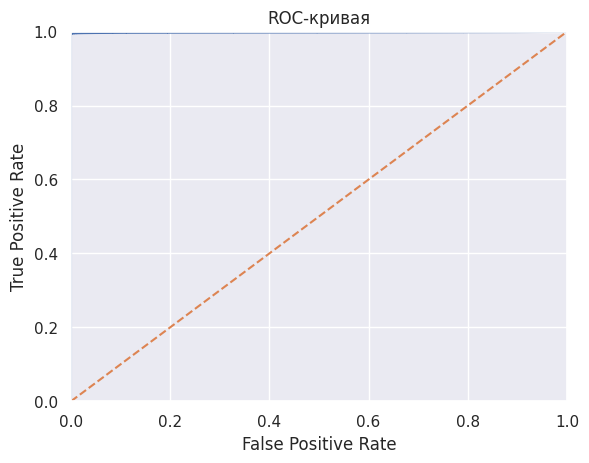

In [107]:
fpr, tpr, thresholds = roc_curve(target_test_cat, predict_test)

plt.figure()

plt.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.show()

Так же определим оптимальынй порог для разделения на классы.

In [108]:
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Значение Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Значение Threshold=0.996688, G-Mean=0.997


In [109]:
analysis = pd.DataFrame()

analysis['track_id'] = features_test_cat['track_id']
analysis['target'] = target_test_cat
analysis['predict'] = predict_test
analysis.head(10)

,track_id,target,predict
19348,fbe76e676348e6c9249a86d460769cd7,1,0.999992
17559,8e6825dc6b2030dbd5953b5139837b37,0,0.989214
23707,eb870e3538e86f8ee3eabf99904d67cd,1,0.999994
37158,137583e5fa336c048b12dd587dedb475,1,0.999999
63737,a812711bf5886f2cfb327cf88147755e,1,0.999999
3164,70f758d081320ab51eaaa02fb7a526ae,1,0.999992
66250,6febe3c7093ce88e31c7cb70c12e5457,1,0.999998
33024,2d4b3888bd53e75d853f284b3d4ba35a,1,0.999999
39720,832ee4aff1558949a1cb2d2da0e7cd99,1,0.999999
8220,79e1b1bd930e2f3889eae81d137593d7,1,0.999992


In [110]:
analysis.loc[analysis['predict'] >= gmeans[ix], 'predict'] = 1
analysis.loc[analysis['predict'] < gmeans[ix], 'predict'] = 0

In [111]:
matrix = confusion_matrix(target_test_cat, predict_test.round())
print(matrix)

[[    5  3644]
 [   17 57191]]


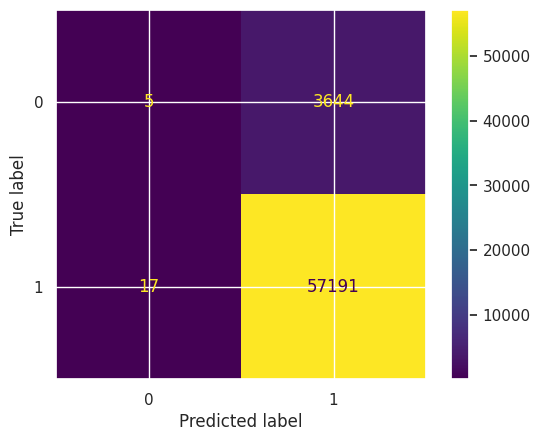

In [112]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

plt.show()

Лучшая модель CatBoostClassifier имеет параметры :   {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.30000000000000004, 'n_estimators': 400, random_state=123456, verbose=100 }
F1 мера на тестовой выборке составляет 0.969 .   
AUC-ROC метрика на тестовой выборке составляет 0.9979 .

Построена матрица ошибок

# Модель для текстов

Рассмотрим модель для текстов на английском языке

In [113]:
data_text = data
data_text = data_text.dropna(subset=['text'])

In [114]:
data_text

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,0,Proud Mary,ROCK,187.22,FI8,1969,ENGLISH,Left a good job in the city\nWorkin' for the m...,ENGLISH
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,0,Fortunate Son,ROCK,137.78,FI8,1969,ENGLISH,Some folks are born made to wave the flag\nOoh...,ENGLISH
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,0,La Camisa Negra,FOLK,216.84,UL1,2004,SPANISH,"Uno por pobre y feo, hombre\nPero antoja'o, ay...",SPANISH
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,0,The Way I Are,RAP,179.66,UM7,2007,ENGLISH,"Yeah!... yeah!... remember the time, baby... y...",ENGLISH
8,None,d6288499d0083cc34e60a077b7c4b3e1,1,Extraball,ELECTRONICS,212.62,8Q1,2009,SPANISH,,ARABIC
...,...,...,...,...,...,...,...,...,...,...,...
72566,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,0,"Милый, прощай",POP,178.98,AGT,2023,RUSSIAN,,ARABIC
72567,None,78b2db35476f134dc3cdfbf4d77ba034,1,Habits (Stay Hight),ELECTRONICS,149.57,AHK,2023,ENGLISH,,ARABIC
72568,None,e720ff378efe032df56e0e656a6a92d3,1,Arcade,BARD,201.58,AHM,2023,SPANISH,,ARABIC
72569,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,0,Май,RAP,156.87,RUS,2023,RUSSIAN,,ARABIC


In [115]:
data_text['lingua'].unique()

array(['ENGLISH', 'SPANISH', 'GERMAN', 'FRENCH', 'RUSSIAN', 'ARABIC',
       'CHINESE'], dtype=object)

In [116]:
data_text

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,0,Proud Mary,ROCK,187.22,FI8,1969,ENGLISH,Left a good job in the city\nWorkin' for the m...,ENGLISH
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,0,Fortunate Son,ROCK,137.78,FI8,1969,ENGLISH,Some folks are born made to wave the flag\nOoh...,ENGLISH
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,0,La Camisa Negra,FOLK,216.84,UL1,2004,SPANISH,"Uno por pobre y feo, hombre\nPero antoja'o, ay...",SPANISH
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,0,The Way I Are,RAP,179.66,UM7,2007,ENGLISH,"Yeah!... yeah!... remember the time, baby... y...",ENGLISH
8,None,d6288499d0083cc34e60a077b7c4b3e1,1,Extraball,ELECTRONICS,212.62,8Q1,2009,SPANISH,,ARABIC
...,...,...,...,...,...,...,...,...,...,...,...
72566,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,0,"Милый, прощай",POP,178.98,AGT,2023,RUSSIAN,,ARABIC
72567,None,78b2db35476f134dc3cdfbf4d77ba034,1,Habits (Stay Hight),ELECTRONICS,149.57,AHK,2023,ENGLISH,,ARABIC
72568,None,e720ff378efe032df56e0e656a6a92d3,1,Arcade,BARD,201.58,AHM,2023,SPANISH,,ARABIC
72569,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,0,Май,RAP,156.87,RUS,2023,RUSSIAN,,ARABIC


In [117]:
data_text[data_text['lingua']!=data_text['lingua_text']]

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
8,None,d6288499d0083cc34e60a077b7c4b3e1,1,Extraball,ELECTRONICS,212.62,8Q1,2009,SPANISH,,ARABIC
20,None,bac4cbb6173335e862a1b3df635ee3ba,1,Bend,METAL,629.91,UM7,2008,GERMAN,,ARABIC
39,None,d7c3f8dee9f1ce4c631160e82f1ec938,1,Live And Let Die,ROCK,182.20,GF1,1991,GERMAN,,ARABIC
40,None,cbb686245ece57c9827c4bc0d0654a8e,1,Have You Ever Seen The Rain,JAZZ,239.62,FI8,1975,ENGLISH,,ARABIC
49,None,c8c83f959021e1042efa4c5146754409,1,Wonderwall,ROCK,248.62,MR1,2003,GERMAN,Today is gonna be the day\nThat they're gonna ...,ENGLISH
...,...,...,...,...,...,...,...,...,...,...,...
72566,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,0,"Милый, прощай",POP,178.98,AGT,2023,RUSSIAN,,ARABIC
72567,None,78b2db35476f134dc3cdfbf4d77ba034,1,Habits (Stay Hight),ELECTRONICS,149.57,AHK,2023,ENGLISH,,ARABIC
72568,None,e720ff378efe032df56e0e656a6a92d3,1,Arcade,BARD,201.58,AHM,2023,SPANISH,,ARABIC
72569,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,0,Май,RAP,156.87,RUS,2023,RUSSIAN,,ARABIC


In [118]:
data_text = data_text[data_text['lingua_text']=='ENGLISH']

In [119]:
data_text

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,0,Proud Mary,ROCK,187.22,FI8,1969,ENGLISH,Left a good job in the city\nWorkin' for the m...,ENGLISH
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,0,Fortunate Son,ROCK,137.78,FI8,1969,ENGLISH,Some folks are born made to wave the flag\nOoh...,ENGLISH
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,0,The Way I Are,RAP,179.66,UM7,2007,ENGLISH,"Yeah!... yeah!... remember the time, baby... y...",ENGLISH
9,None,4da9d7b6d119db4d2d564a2197798380,1,Can't Buy Me Love,JAZZ,158.95,GR1,2001,ENGLISH,Can't buy me love\nCan't buy me love\nCan't bu...,ENGLISH
10,None,2bf283c05b601f21364d052ca0ec798d,1,She's Leaving Home,JAZZ,356.07,GR1,1999,ENGLISH,Wednesday morning at five o'clock\nAs the day ...,ENGLISH
...,...,...,...,...,...,...,...,...,...,...,...
72405,None,63d1c29c0aa3d4f8ed33d6d62d50aac5,1,Walking Away,ROCK,197.54,M95,2023,ENGLISH,I'm walking away\nFrom the troubles in my life...,ENGLISH
72420,711bcb5789694e6842f57fe6d722a142,711bcb5789694e6842f57fe6d722a142,0,IF I EVER,RAP,137.13,AGV,2023,ENGLISH,If I gave them all I had you know I'd probably...,ENGLISH
72452,None,2a72ce548d172eda9964a2bbb6c4e08e,1,Zombie,DANCE,171.27,8KE,2023,FRENCH,Another head hangs lowly\nChild is slowly take...,ENGLISH
72461,None,b91eab26ef51b751ce8fd0e39a7a20d7,1,April Come She Will,ROCK,110.18,M95,2023,ENGLISH,"April, come she will\nWhen streams are ripe an...",ENGLISH


In [120]:
data_text = data_text.dropna(subset=['text'])

In [121]:
corpus = list(data_text['text'])
display(corpus)

["Left a good job in the city\nWorkin' for the man ev'ry night and day\nAnd I never lost one minute of sleepin'\nWorryin' 'bout the way things might have been\n\nBig wheel keep on turnin'\nProud Mary keep on burnin'\nRollin', rollin', rollin' on the river\n\nCleaned a lot of plates in Memphis\nPumped a lot of 'pane down in New Orleans\nBut I never saw the good side of a city\n'Til I hitched a ride on a riverboat queen\n\nBig wheel keep on turnin'\nProud Mary keep on burnin'\nRollin', rollin', rollin' on the river\n\nRollin', rollin', rollin' on the river\n\nIf you come down to the river\nBet you gonna find some people who live\nYou don't have to worry 'cause you have no money\nPeople on the river are happy to give\n\nBig wheel keep on turnin'\nProud Mary keep on burnin'\nRollin', rollin', rollin' on the river\nRollin', rollin', rollin' on the river\nRollin', rollin', rollin' on the river\nRollin', rollin', rollin' on",
 'Some folks are born made to wave the flag\nOoh, they\'re red, whi

In [122]:
lemmatizer = WordNetLemmatizer()

In [123]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [124]:
def clear_text(text):
    cl_text = text.lower()
    cl_text = re.sub(r'[^a-zA-Z]', ' ', str(cl_text))
    cl_text = ' '.join(cl_text.split())
    return cl_text

In [125]:
tqdm.pandas()

In [126]:
def lemmatize(text):
    k=[]
    for w in nltk.word_tokenize(text):
        y=lemmatizer.lemmatize(w, get_wordnet_pos(w))
        k.append(y)
    return ' '.join(k)

data_text['lemm_text'] = data_text['text'].progress_apply(clear_text)
data_text['lemm_text'] = data_text['lemm_text'].progress_apply(lemmatize)

  0%|          | 0/6089 [00:00<?, ?it/s]

  0%|          | 0/6089 [00:00<?, ?it/s]

In [127]:
print("Исходный текст:", corpus[0])
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[0])))

Исходный текст: Left a good job in the city
Workin' for the man ev'ry night and day
And I never lost one minute of sleepin'
Worryin' 'bout the way things might have been

Big wheel keep on turnin'
Proud Mary keep on burnin'
Rollin', rollin', rollin' on the river

Cleaned a lot of plates in Memphis
Pumped a lot of 'pane down in New Orleans
But I never saw the good side of a city
'Til I hitched a ride on a riverboat queen

Big wheel keep on turnin'
Proud Mary keep on burnin'
Rollin', rollin', rollin' on the river

Rollin', rollin', rollin' on the river

If you come down to the river
Bet you gonna find some people who live
You don't have to worry 'cause you have no money
People on the river are happy to give

Big wheel keep on turnin'
Proud Mary keep on burnin'
Rollin', rollin', rollin' on the river
Rollin', rollin', rollin' on the river
Rollin', rollin', rollin' on the river
Rollin', rollin', rollin' on
Очищенный и лемматизированный текст: left a good job in the city workin for the man e

1    0.852849
0    0.147151
Name: track_remake_type, dtype: float64


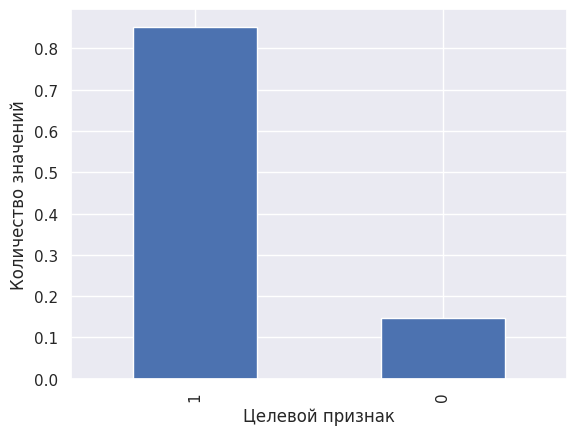

In [128]:
class_frequency = data_text['track_remake_type'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xlabel('Целевой признак')
plt.ylabel('Количество значений');

In [129]:
target = data_text['track_remake_type']

In [130]:
train, test = train_test_split(data_text, stratify=target, test_size=0.15)

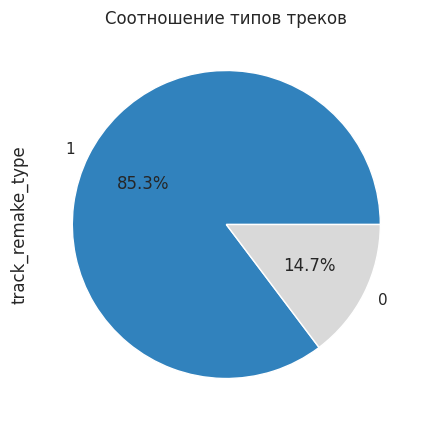

In [131]:
target.value_counts().plot.pie(title = 'Соотношение типов треков' ,
                                                 colormap = 'tab20c', figsize = (5,5), autopct='%1.1f%%')
plt.show()

In [132]:
train

,original_track_id,track_id,track_remake_type,title,genres,duration,artist,year,lingua,text,lingua_text,lemm_text
33983,None,ddaf15f8ed1f45867b1277d8b53a0dae,1,S.O.S.,POP,175.570,AFL,2021,SPANISH,Where are those happy days\nThey seem to hard ...,ENGLISH,where be those happy day they seem to hard to ...
42053,None,545aaec9633552f81630ada1170ea7a6,1,Born to Make U Happy,POP,228.510,HZ6,2021,ENGLISH,I'm sitting here alone up in my room\nAnd thin...,ENGLISH,i m sit here alone up in my room and think abo...
1786,None,866e88d90133f870254ca8a486dd4cf5,1,Eenie Meenie,POP,206.158,9VH,2010,GERMAN,For all the times that you rain on my parade\n...,ENGLISH,for all the time that you rain on my parade an...
9384,None,46e6c65f420fe63dd45fbcd9fbeb8e12,1,Wildest Dreams,POP,211.910,6KW,2015,ENGLISH,"He said, ""Let's get out of this town,\nDrive o...",ENGLISH,he say let s get out of this town drive out of...
29402,None,9f210af045448e8ef2eff32be7ee2ee1,1,Both Sides Now,ROCK,257.930,FMF,2020,ENGLISH,Rows and flows of angel hair\nAnd ice cream ca...,ENGLISH,row and flow of angel hair and ice cream castl...
...,...,...,...,...,...,...,...,...,...,...,...,...
28841,None,2d949b0517e9091bafced1522591570f,1,Jump Into The Fire,ALTERNATIVE,215.690,UG1,2020,ENGLISH,You can climb a mountain\nYou can swim the sea...,ENGLISH,you can climb a mountain you can swim the sea ...
28562,None,c9371e57714443502d94efa0f7b1137e,1,Fast Car,ELECTRONICS,177.370,F41,2020,ENGLISH,"You got a fast car, I want a ticket to anywher...",ENGLISH,you get a fast car i want a ticket to anywhere...
1334,None,a5d64aa03dfec9bacaf2f36ec474a504,1,Carry on,METAL,311.650,N26,2009,ENGLISH,Simple minded brain\nFor now you succumb\nNoth...,ENGLISH,simple mind brain for now you succumb nothing ...
7895,None,57ab38f91d5f53a7d33168a4a55e5c6a,1,Mercy,POP,223.850,UM7,2008,ENGLISH,I love you\nBut I gotta stay true\nMy morals g...,ENGLISH,i love you but i get ta stay true my moral get...


In [133]:
# nltk.download('stopwords')
# #stopwords = set(nltk_stopwords.words('english'))

In [134]:
# count_tf_idf = TfidfVectorizer(stop_words='english')
# tf_idf_features_train = count_tf_idf.fit_transform(train['lemm_text'])
# tf_idf_features_test = count_tf_idf.transform(test['lemm_text'])
# print("Размер матриц:", tf_idf_features_train.shape, tf_idf_features_test.shape)

## Логистическая регрессия

In [135]:
pipeline_lr = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words='english')),
        ("lr", LogisticRegression(random_state=RANDOM_STATE, max_iter=200,  class_weight='balanced', solver='liblinear'))
    ]
)
pipeline_lr

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    random_state=123456, solver='liblinear'))])

In [136]:
param_grid_pipeline = {'lr__C': [100]}
# param_grid_pipeline = {'lr__C': [0.1, 1, 10, 100]}
lr_grid_pipeline = GridSearchCV(estimator=pipeline_lr, param_grid = param_grid_pipeline, cv=3, scoring='f1')
lr_grid_pipeline.fit(train['lemm_text'], train['track_remake_type'])

print('Гиперпараметры лучшей модели:', lr_grid_pipeline.best_params_)
print('Значение F1 для лучшей модели LogisticRegression: {:.2f}'.format(lr_grid_pipeline.best_score_))

Гиперпараметры лучшей модели: {'lr__C': 100}
Значение F1 для лучшей модели LogisticRegression: 0.86


Поиск гиперпараметров осуществлялся по данным:  
param_grid_pipeline = {'lr__C': [0.1, 1, 10, 100]},  
получились гиперпараметры лучшей модели: {'lr__C': 100}

In [137]:
print(lr_grid_pipeline.best_estimator_)

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('lr',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=200, random_state=123456,
                                    solver='liblinear'))])


## Дерево решений

In [138]:
features_train = train.drop(['text','track_remake_type'], axis=1)
target_train = train['track_remake_type']

features_test = test.drop(['text','track_remake_type'], axis=1)
target_test = test['track_remake_type']

In [139]:
count_tf_idf = TfidfVectorizer(stop_words='english')
tf_idf_features_train = count_tf_idf.fit_transform(train['lemm_text'])
tf_idf_features_test = count_tf_idf.transform(test['lemm_text'])
print("Размер матриц:", tf_idf_features_train.shape, tf_idf_features_test.shape)

Размер матриц: (5175, 16171) (914, 16171)


In [140]:
tf_idf_features_train_dtc = tf_idf_features_train.copy()
target_train_dtc = target_train.copy()

In [141]:
# pipeline_dtc = Pipeline(
#     [
#         ("vect", TfidfVectorizer(stop_words='english')),
#         ("dtc", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
#     ]
# )
# pipeline_dtc

In [142]:
# parametrs_dtc = { 'dtc__max_depth' : range (70, 80)}

# dtc_grid = GridSearchCV(estimator=ppipeline_dtc, parametrs_dtc, n_jobs = -1,  scoring=f1, cv=3)
# dtc_grid.fit(tf_idf_features_train_dtc, target_train_dtc)

# print('Гиперпараметры лучшей модели:', dtc_grid.best_params_)

# print('Значение F1 для лучшей модели DecisionTreeClassifier: {:.2f}'.format(dtc_grid.best_score_))

In [143]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
parametrs_dtc = { 'max_depth' : range (70, 80)}

dtc_grid = GridSearchCV(dtc, parametrs_dtc, n_jobs = -1,  scoring='f1', cv=3)
dtc_grid.fit(tf_idf_features_train_dtc, target_train_dtc)

print('Гиперпараметры лучшей модели:', dtc_grid.best_params_)

print('Значение F1 для лучшей модели DecisionTreeClassifier: {:.2f}'.format(dtc_grid.best_score_))

Гиперпараметры лучшей модели: {'max_depth': 79}
Значение F1 для лучшей модели DecisionTreeClassifier: 0.83


**Выводы:**  
Значение F1 для лучшей модели LogisticRegression: 0.86.    
Значение F1 для лучшей модели DecisionTreeClassifier: 0.83.  
Протестируем модель LogisticRegression

## Тестирование модели

In [144]:
features_train = train.drop(['text','track_remake_type'], axis=1)
target_train = train['track_remake_type']

features_test = test.drop(['text','track_remake_type'], axis=1)
target_test = test['track_remake_type']

In [145]:
nltk.download('stopwords')
#stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [146]:
count_tf_idf = TfidfVectorizer(stop_words='english')
tf_idf_features_train = count_tf_idf.fit_transform(train['lemm_text'])
tf_idf_features_test = count_tf_idf.transform(test['lemm_text'])
print("Размер матриц:", tf_idf_features_train.shape, tf_idf_features_test.shape)

Размер матриц: (5175, 16171) (914, 16171)


In [147]:
lr_grid_pipeline.best_estimator_

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('lr',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=200, random_state=123456,
                                    solver='liblinear'))])

In [148]:
predictions_test_lg = lr_grid_pipeline.best_estimator_.predict(test['lemm_text'])
result = f1_score(target_test, predictions_test_lg)
print('Значение F1 для лучшей модели LogisticRegression на тестовой выборке {:.2f}'.format(result))


Значение F1 для лучшей модели LogisticRegression на тестовой выборке 0.87


In [149]:
target_test.head(20)

31817    0
4133     1
1074     1
7414     1
39997    1
33945    1
33622    1
72174    1
19449    1
19084    1
2289     1
9930     1
18165    1
22611    1
43587    1
40672    1
50494    1
43583    1
8961     1
25228    1
Name: track_remake_type, dtype: int64

**Выводы:**  

Была проведена очистка текста, лемматизация, векторизация. Была произведена балансировка данных.
Построена модель для определения кавера по тексту    
Параметры лучшей модели  
 LogisticRegression {C=100, class_weight='balanced',  
                                    max_iter=200, random_state=123456,  
                                    solver='liblinear'}    
Значение F1 меры для лучшей модели LogisticRegression на тестовой выборке: 0.87.

## Кластеризация

In [150]:
# data_cluster[data_cluster['title']=='Everlasting Love']

In [151]:
# data_cluster_original = data_cluster.dropna(subset=['original_track_id'])
# data_cluster_original

In [152]:
# data_cluster[data_cluster['original_track_id']!=data_cluster['track_id']]

In [153]:
# x = data_cluster[data_cluster['original_track_id']!=data_cluster['track_id']]
# x['original_track_id'].nunique()

In [154]:
# x['track_id'].nunique()

In [155]:
# y = data_cluster[data_cluster['lemm_text'].duplicated ()]

In [156]:
# y[y['lemm_text'].duplicated ()]

In [157]:
# features= data_cluster.drop(['original_track_id'], axis=1)
# target = data_cluster['original_track_id']

In [158]:
# features_train_2, features_test_2, target_train_2, target_test_2 = train_test_split(features_2, target_2, stratify=target,
#                                                                             test_size=0.25, random_state=RANDOM_STATE)

In [159]:
# features_train_2.columns

In [160]:
# cat_features = ['original_track_id', 'track_id',  'title',
#        'genres',  'artist', 'lingua', 'text']

In [161]:
# num_features = ['year', 'duration' ,'track_remake_type']

In [162]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline(steps=[('scaler', StandardScaler())]), num_features),
#         ('cat', Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))    ]), cat_features)
#     ]
# )

In [163]:
# pipeline_2 = Pipeline(
#     [
#         ('preprocessor', preprocessor),
#         ('rfc', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
#     ]
# )
# pipeline_2

In [164]:
# param_grid_pipeline ={'rfc__max_depth': [5], #10,30],
#                       'rfc__n_estimators': [100], #,200,300],
#                       'rfc__max_leaf_nodes': [50]} #, 80]}

# rfc_grid_pipeline = GridSearchCV(estimator=pipeline_2, param_grid = param_grid_pipeline, cv=3, scoring=f1)
# rfc_grid_pipeline.fit(features_train_2, target_train_2)

# print('Гиперпараметры лучшей модели:', rfc_grid_pipeline.best_params_)

# print('Значение ROC_AUC для лучшей модели RandomForestClassifier: {:.2f}'.format(rfc_grid_pipeline.best_score_))


In [165]:
# cluster_orig_track = data_cluster.groupby(['track_remake_type'], group_keys=False).apply(lambda x: x)
# cluster_orig_track

In [166]:
# cat_features = ['original_track_id', 'track_id',  'title',
#        'genres',  'artist', 'lingua', 'text']

In [167]:
# num_features = ['year', 'duration']

In [168]:
# preprocessor_cluster = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline(steps=[('scaler', StandardScaler())]), num_features),
#         ('cat', Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))    ]), cat_features)
#     ]
# )

In [169]:
# pipeline_cluster = Pipeline(
#     [
#         ('preprocessor_cluster', preprocessor)
#     ]
# )
# pipeline_cluster

In [170]:
# as = pipeline_cluster.transform(data_bert)

In [171]:
# scaler.fit(features_train[numeric]) # < напишите код здесь >

# features_train[numeric] = scaler.transform(features_train[numeric])
# features_valid[numeric] = scaler.transform(features_valid[numeric])

In [172]:
# data_bert = data_bert.pipeline_cluster

In [173]:
# from sklearn.cluster import KMeans

# data_2 = data_bert
# centers = np.array([[20, 80, 8], [50, 20, 5], [20, 30, 10]])

# model = KMeans(n_clusters=3, random_state=12345)
# model.fit(data_2)

# print("Центроиды кластеров:")
# print(model.cluster_centers_)

# # Обучение модели с начальными центроидами
# model = KMeans(n_clusters=3, random_state=12345, init=centers) # < напишите код здесь >
# model.fit(data_2) # < напишите код здесь >

# print("Центроиды кластеров для модели с начальными центроидами:")
# print(model.cluster_centers_)# < напишите код здесь >)